In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import tensorflow as tf
from ast import literal_eval
from collections import Counter
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Datasets/tweetsand.csv')

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Datasets/tweetswith2t.csv")

In [ ]:
df

,text,timestamp,sentiment,timestamp1
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon Apr 06 22:19:45 PDT 2009,negative,2009-04-06 22:19:45+00:00
1,is upset that he can't update his Facebook by ...,Mon Apr 06 22:19:49 PDT 2009,negative,2009-04-06 22:19:49+00:00
2,@Kenichan I dived many times for the ball. Man...,Mon Apr 06 22:19:53 PDT 2009,negative,2009-04-06 22:19:53+00:00
3,my whole body feels itchy and like its on fire,Mon Apr 06 22:19:57 PDT 2009,negative,2009-04-06 22:19:57+00:00
4,"@nationwideclass no, it's not behaving at all....",Mon Apr 06 22:19:57 PDT 2009,negative,2009-04-06 22:19:57+00:00
...,...,...,...,...
1612303,(Via FC) Apple Is Warming Up To Social Media -...,Tue Dec 09 22:08:53 +0000 2014,neutral,2014-12-09 22:08:53+00:00
1612304,RT @MMLXIV: there is no avocado emoji may I as...,Tue Dec 09 22:18:27 +0000 2014,neutral,2014-12-09 22:18:27+00:00
1612305,@marcbulandr I could not agree more. Between @...,Tue Dec 09 23:45:59 +0000 2014,positive,2014-12-09 23:45:59+00:00
1612306,My iPhone 5's photos are no longer downloading...,Wed Dec 10 00:48:10 +0000 2014,negative,2014-12-10 00:48:10+00:00


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [ ]:
df['sentiment'].value_counts()

negative    805954
positive    802031
neutral       4323
Name: sentiment, dtype: int64

In [ ]:
min_rows = df['sentiment'].value_counts().min()

In [ ]:
def sampling_k_elements(group, k=min_rows):
    if len(group) < k:
        return group
    return group.sample(k)

balanced = df.groupby('sentiment').apply(sampling_k_elements).reset_index(drop=True)

In [ ]:
balanced['sentiment'].value_counts()

negative    4323
neutral     4323
positive    4323
Name: sentiment, dtype: int64

# Model Building

In [ ]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [ ]:
balanced['desc_words'] = balanced['text'].apply(preprocess_tweet)

In [ ]:
def encode_text(df,column,max_words):
    all_words=[]
    for i in df[column].values:
        words=i.split(" ")
        for word in words:
            all_words.append("".join(word))

    # Frequency of each word
    words = nltk.tokenize.word_tokenize(" ".join(all_words))
    fdist = FreqDist(words)

    # Most frequent words
    mfw={}
    count=1
    for i in fdist.most_common(max_words):
        mfw[i[0]]=count
        count+=1

    # Encoding the text
    X=[]
    for i in df['desc_words'].values:
        X.append([mfw[i] for i in i.split(' ') if i in mfw.keys()])
    df['encoded_text']=X

In [ ]:
encode_text(balanced,'desc_words',5000)

In [ ]:
balanced.columns

Index(['text', 'timestamp', 'sentiment', 'timestamp1', 'desc_words',
       'encoded_text'],
      dtype='object')

In [ ]:
def train_model(df,model_name,field="text_desc",feature_rep="binary",top_k=3):

    if not os.path.exists('models/'+model_name):
        os.makedirs('models/'+model_name)
    path='models/'+model_name+'/'
    logging.info("Starting model training...")
    
    training_data, testing_data = train_test_split(df,random_state = 2000,)

    Y_train=training_data['sentiment'].values
    Y_test=testing_data['sentiment'].values
     
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    logging.info("Training a "+model_name+" Model...")

    if model_name=='cnn':
        X_train=training_data['encoded_text'].values
        X_test=testing_data['encoded_text'].values
        le=LabelEncoder()
        Y_train=le.fit_transform(Y_train)
        Y_test=le.fit_transform(Y_test)
        # Longest text
        hig=0
        for i in X_train:
            if len(i)>hig:
                hig=len(i)
        max_words = hig
        X_train = pad_sequences(X_train, maxlen=max_words)
        X_test = pad_sequences(X_test, maxlen=max_words)

        model = Sequential()
        model.add(Embedding(100001, 32, input_length=max_words))
        model.add(Conv1D(32, 3, padding='same', activation='relu'))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(250, activation='relu'))
        model.add(Dense(3, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3)

        model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=128, verbose=1, callbacks=[es])
        preds=model.predict(X_test)

        scores = model.evaluate(X_test, Y_test, verbose=0)

        print("Accuracy: %.2f%%" % (scores[1]*100))
    elif model_name=='lstm':
        X_train=training_data['encoded_text'].values
        X_test=testing_data['encoded_text'].values
        le=LabelEncoder()
        Y_train=le.fit_transform(Y_train)
        Y_test=le.fit_transform(Y_test)
        # Longest text
        hig=0
        for i in X_train:
            if len(i)>hig:
                hig=len(i)
        max_words = hig
        X_train = pad_sequences(X_train, maxlen=max_words)
        X_test = pad_sequences(X_test, maxlen=max_words)

        model = Sequential()
        model.add(Embedding(100001, 32, input_length=max_words))
        model.add(Dropout(0.4))
        model.add(LSTM(128))
        model.add(Dense(250, activation='relu'))
        model.add(Dense(3, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3)


        model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128, verbose=1, callbacks=[es])

        scores = model.evaluate(X_test, Y_test, verbose=0)

        print("Accuracy: %.2f%%" % (scores[1]*100))

    else:
        model_ = model_dict[model_name]
        model = model_.fit(X_train,Y_train)


    if model_name=='svm':
        preds=get_top_k_predictions(model,X_test,top_k,svm=True,lstm=False,cnn=False)
    elif  model_name!='lstm' and model_name!='cnn':
        preds=get_top_k_predictions(model,X_test,top_k,svm=False,lstm=False,cnn=False)
    elif model_name=='lstm':
        preds=get_top_k_predictions(model,X_test,top_k,svm=False,lstm=True,cnn=False)
    else:
        preds=get_top_k_predictions(model,X_test,top_k,svm=False,lstm=False,cnn=True)
    
    eval_items=collect(Y_test,preds)
    
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    if model_name=='svm':
        results[model_name+'_preds']=preds
        train_preds=get_top_k_predictions(model,X_train,top_k,svm=True,lstm=False,cnn=False)
    elif  model_name!='lstm' and model_name!='cnn':
        results[model_name+'_preds']=preds
        train_preds=get_top_k_predictions(model,X_train,top_k,svm=False,lstm=False,cnn=False)
    elif model_name == 'cnn':
        results[model_name+'_preds']=[list(le.classes_[pred_cat]) for pred_cat in preds]
        train_preds=get_top_k_predictions(model,X_train,top_k,svm=False,lstm=False,cnn=True)
        train_preds=[list(le.classes_[pred_cat]) for pred_cat in train_preds]
        Y_train = [le.classes_[value] for value in Y_train]
        Y_test = [le.classes_[value] for value in Y_test]
    else:
        results[model_name+'_preds']=[list(le.classes_[pred_cat]) for pred_cat in preds]
        train_preds=get_top_k_predictions(model,X_train,top_k,svm=False,lstm=False,cnn=True)
        train_preds=[list(le.classes_[pred_cat]) for pred_cat in train_preds]
        Y_train = [le.classes_[value] for value in Y_train]
        Y_test = [le.classes_[value] for value in Y_test]    

    df_train_preds = pd.DataFrame(zip(train_preds[-100:],Y_train[-100:]),columns=['Predicted (Train)','True (Train)'])
    df_test_preds = pd.DataFrame(zip(results[model_name+'_preds'].values[-100:],Y_test[-100:]),columns=['Predicted (Test)','True (Test)'])



    print('train_preds: ',len(train_preds))
    print('timestamp1: ' ,training_data['timestamp1'].shape)

    df_full_train_preds = pd.DataFrame(zip(train_preds,Y_train,training_data['timestamp1'].values),columns=['Predicted (Train)','True (Train)','Timestamp'])
    df_full_test_preds = pd.DataFrame(zip(results[model_name+'_preds'].values,Y_test,testing_data['timestamp1'].values),columns=['Predicted (Test)','True (Test)','Timestamp'])
    
    df_train_preds.to_csv(path+model_name+'_train_preds.csv',index=False)
    df_test_preds.to_csv(path+model_name+'_test_preds.csv',index=False)

    df_full_train_preds.to_csv(path+model_name+'_full_train_preds.csv',index=False)
    df_full_test_preds.to_csv(path+model_name+'_full_test_preds.csv',index=False)    

    if  model_name!='lstm' and model_name!='cnn':
        with open(path+'transformer.pkl', 'wb') as file:
            pickle.dump(feature_transformer, file)
        with open(path+model_name+'_model.pkl', 'wb') as file:
            pickle.dump(model, file)
        with open(path+model_name+'_accuracy.pkl', 'wb') as file:
            pickle.dump(accuracy, file)
        with open(path+model_name+'_mrr_at_k.pkl', 'wb') as file:
            pickle.dump(mrr_at_k, file)
    else:
        model.save(path+model_name+"_model.h5")
        with open(path+model_name+'_accuracy.pkl', 'wb') as file:
            pickle.dump(accuracy, file)
        with open(path+model_name+'_mrr_at_k.pkl', 'wb') as file:
            pickle.dump(mrr_at_k, file)
    return model,feature_transformer,accuracy,mrr_at_k


def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer
    
def get_top_k_predictions(model,X_test,k,svm,lstm,cnn):
    if svm:
        probs = model._predict_proba_lr(X_test)
    else:
        probs = model.predict_proba(X_test)
    best_n = np.argsort(probs, axis=1)[:,-k:]
    if not lstm and not cnn:
        preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    else:
        preds=[[predicted_cat for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    
    return preds

def collect(Y_test,Y):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y)]
    
    return pred_gold_list

def compute_accuracy(eval_items:list):
    
    correct=0
    total=0
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    accuracy=correct/float(len(eval_items))
    
    return accuracy

def _reciprocal_rank(true_labels: list, machine: list):
    """Compute the reciprocal rank at cutoff k"""
    
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine) if r in true_labels]
    rr = 0
    if len(tp_pos_list) > 0:
        first_pos_list = tp_pos_list[0] 
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    
    rr_total = 0
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

In [ ]:
model_dict={'LogisticRegression':LogisticRegression(verbose=1, solver='liblinear', C=5, penalty='l2',max_iter=1000),
            'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=25),
            'RandomForestClassifier':RandomForestClassifier(n_estimators = 10,verbose=3,n_jobs=-1),
            'MultinomialNB':MultinomialNB(),
            'XGBClassifier':XGBClassifier(max_depth=3, n_estimators=400,verbosity=1),
            'svm':svm.LinearSVC(C=0.1),
            'MLPClassifier':MLPClassifier(solver='lbfgs', alpha=1e-5,max_iter=1000,hidden_layer_sizes=(5, 2))}

# cnn, lstm

In [ ]:
field='desc_words'
feature_rep='tfidf'
top_k=1

In [ ]:
results = pd.DataFrame()

In [ ]:
#data=df
data=balanced
for i in model_dict.keys():
    model_name=i

    model,transformer,accuracy,mrr_at_k=train_model(data,model_name,field=field,feature_rep=feature_rep,top_k=top_k)

    print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

[LibLinear]train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.7533148319457292; MRR=0.7533148319457292
train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.6413814369411039; MRR=0.6413814369411039


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.6854764107308048; MRR=0.6854764107308048
train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.736663583102066; MRR=0.736663583102066
train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.7298797409805735; MRR=0.7298797409805735
train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.7560900400863398; MRR=0.7560900400863398
train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.6823928461301264; MRR=0.6823928461301264


In [ ]:
#data=df
data=balanced

model_name='cnn'

model,transformer,accuracy,mrr_at_k=train_model(data,model_name,field=field,feature_rep=feature_rep,top_k=1)

print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 32)            3200032   
_________________________________________________________________
conv1d (Conv1D)              (None, 31, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               120250    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 753       
Total params: 3,324,139
Trainable params: 3,324,139
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.7360468701819303; MRR=0.7360468701819303


In [ ]:
#data=df
data=balanced

model_name='lstm'

model,transformer,accuracy,mrr_at_k=train_model(data,model_name,field=field,feature_rep=feature_rep,top_k=1)

print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 32)            3200032   
_________________________________________________________________
dropout (Dropout)            (None, 31, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 250)               32250     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 753       
Total params: 3,315,467
Trainable params: 3,315,467
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
76/76 [==============================] - 18s 155ms/step - loss: 1.0122 - accuracy: 0.4663 - val

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


train_preds:  9726
timestamp1:  (9726,)

Accuracy=0.7258711069996916; MRR=0.7258711069996916


In [ ]:
results

,LogisticRegression_preds,DecisionTreeClassifier_preds,RandomForestClassifier_preds,MultinomialNB_preds,XGBClassifier_preds,svm_preds,MLPClassifier_preds,cnn_preds,lstm_preds
0,[negative],[positive],[positive],[negative],[positive],[negative],[negative],[negative],[negative]
1,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral]
2,[negative],[negative],[negative],[negative],[negative],[negative],[negative],[negative],[negative]
3,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral]
4,[positive],[positive],[neutral],[positive],[neutral],[neutral],[positive],[positive],[positive]
...,...,...,...,...,...,...,...,...,...
3238,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[positive],[neutral],[neutral]
3239,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral]
3240,[negative],[negative],[negative],[positive],[negative],[negative],[negative],[positive],[positive]
3241,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral]


In [ ]:
majority_vote=[]
for i in results.itertuples():
    all_cat=[]
    for j in i[1:]:
        all_cat=all_cat+j
    majority_vote.append([k[0] for k in Counter(all_cat).most_common(1)])

In [ ]:
results['majority_vote']=majority_vote

In [ ]:
results.head(2)

,LogisticRegression_preds,DecisionTreeClassifier_preds,RandomForestClassifier_preds,MultinomialNB_preds,XGBClassifier_preds,svm_preds,MLPClassifier_preds,cnn_preds,lstm_preds,majority_vote
0,[negative],[positive],[positive],[negative],[positive],[negative],[negative],[negative],[negative],[negative]
1,[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral],[neutral]


In [ ]:
#data=df
data=balanced

training_data, testing_data = train_test_split(data,random_state = 2000,)

Y_train=training_data['sentiment'].values
Y_test=testing_data['sentiment'].values

In [ ]:
eval_items=collect(Y_test,majority_vote)

In [ ]:
accuracy=compute_accuracy(eval_items)
accuracy

0.7628738822078323

In [ ]:
mrr_at_k=compute_mrr_at_k(eval_items)
mrr_at_k

0.7628738822078323

In [ ]:
if not os.path.exists('models/'+'MajorityVote'):
    os.makedirs('models/'+'MajorityVote')

results.to_csv('models/MajorityVote/'+'majority_vote_results.csv', index=False)

with open('models/MajorityVote/'+'majority_vote_accuracy.pkl', 'wb') as file:
    pickle.dump(accuracy, file)
with open('models/MajorityVote/'+'majority_vote_mrr_at_k.pkl', 'wb') as file:
    pickle.dump(mrr_at_k, file)

In [ ]:
results= pd.read_csv("models/MajorityVote/majority_vote_results.csv")

In [ ]:
results

,LogisticRegression_preds,DecisionTreeClassifier_preds,RandomForestClassifier_preds,MultinomialNB_preds,XGBClassifier_preds,svm_preds,MLPClassifier_preds,cnn_preds,lstm_preds,majority_vote
0,['negative'],['positive'],['positive'],['negative'],['positive'],['negative'],['negative'],['negative'],['negative'],['negative']
1,['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral']
2,['negative'],['negative'],['negative'],['negative'],['negative'],['negative'],['negative'],['negative'],['negative'],['negative']
3,['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral']
4,['positive'],['positive'],['neutral'],['positive'],['neutral'],['neutral'],['positive'],['positive'],['positive'],['positive']
...,...,...,...,...,...,...,...,...,...,...
3238,['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['positive'],['neutral'],['neutral'],['neutral']
3239,['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral']
3240,['negative'],['negative'],['negative'],['positive'],['negative'],['negative'],['negative'],['positive'],['positive'],['negative']
3241,['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral'],['neutral']


In [ ]:
for column in results.columns:
    results[column]=results[column].apply(lambda x:literal_eval(x))
    results[column]=results[column].apply(lambda x:x[0])

In [ ]:
results.columns

Index(['LogisticRegression_preds', 'DecisionTreeClassifier_preds',
       'RandomForestClassifier_preds', 'MultinomialNB_preds',
       'XGBClassifier_preds', 'svm_preds', 'MLPClassifier_preds', 'cnn_preds',
       'lstm_preds', 'majority_vote'],
      dtype='object')

In [ ]:
results.columns=['Logistic Regression','Decision Tree Classifier','Random Forest Classifier', 'Multinomial Naive Bayes',
       'XGB Classifier', 'SVM', 'MLP Classifier', 'CNN',
       'LSTM', 'Majority Vote']

In [ ]:
results

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes,XGB Classifier,SVM,MLP Classifier,CNN,LSTM,Majority Vote
0,negative,positive,positive,negative,positive,negative,negative,negative,negative,negative
1,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
2,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative
3,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
4,positive,positive,neutral,positive,neutral,neutral,positive,positive,positive,positive
...,...,...,...,...,...,...,...,...,...,...
3238,neutral,neutral,neutral,neutral,neutral,neutral,positive,neutral,neutral,neutral
3239,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
3240,negative,negative,negative,positive,negative,negative,negative,positive,positive,negative
3241,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral


In [ ]:
results['Timestamp'] = testing_data['timestamp1'].values

In [ ]:
results 

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes,XGB Classifier,SVM,MLP Classifier,CNN,LSTM,Majority Vote,Timestamp
0,negative,positive,positive,negative,positive,negative,negative,negative,negative,negative,2009-06-03 01:16:06+00:00
1,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2014-12-02 13:33:19+00:00
2,negative,negative,negative,negative,negative,negative,negative,negative,negative,negative,2009-06-01 07:06:42+00:00
3,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2014-12-09 15:41:08+00:00
4,positive,positive,neutral,positive,neutral,neutral,positive,positive,positive,positive,2015-02-22 07:54:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
3238,neutral,neutral,neutral,neutral,neutral,neutral,positive,neutral,neutral,neutral,2014-12-02 21:00:23+00:00
3239,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2015-02-23 06:09:00+00:00
3240,negative,negative,negative,positive,negative,negative,negative,positive,positive,negative,2009-06-16 01:20:39+00:00
3241,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2014-12-09 01:38:34+00:00


In [ ]:
results.to_csv('full_results.csv', index = False)

# Confusion Matrix

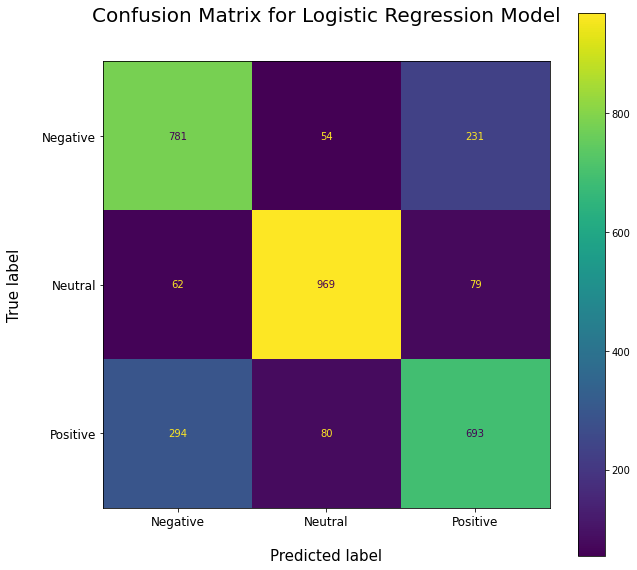

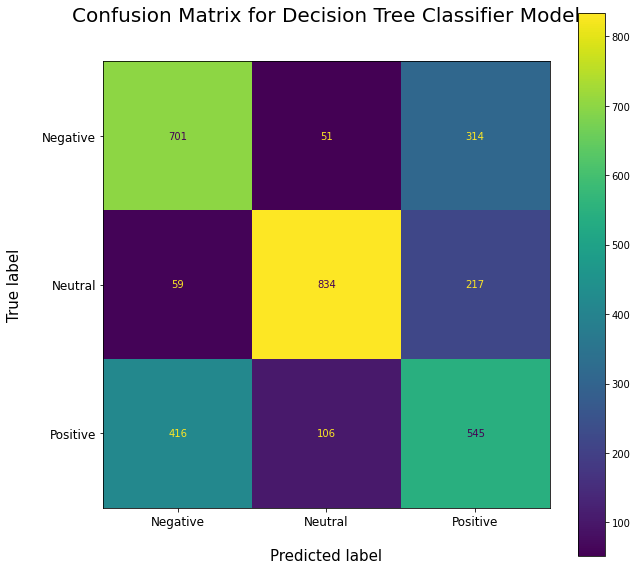

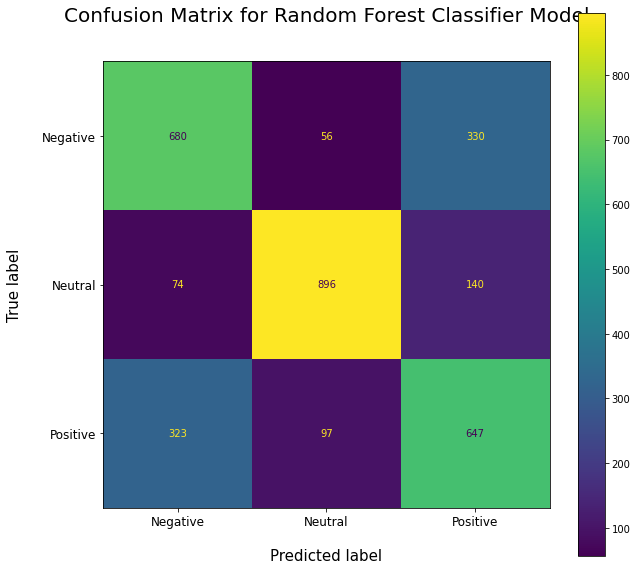

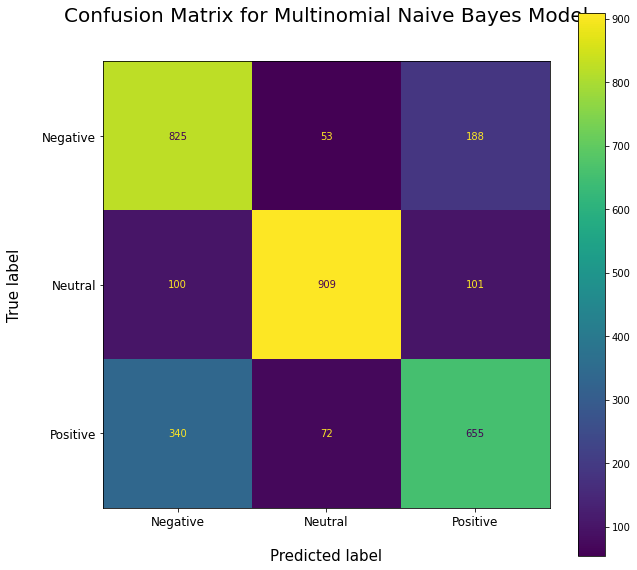

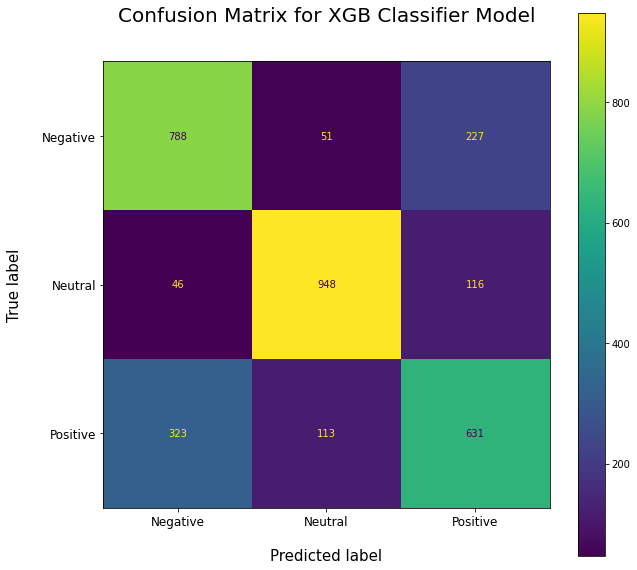

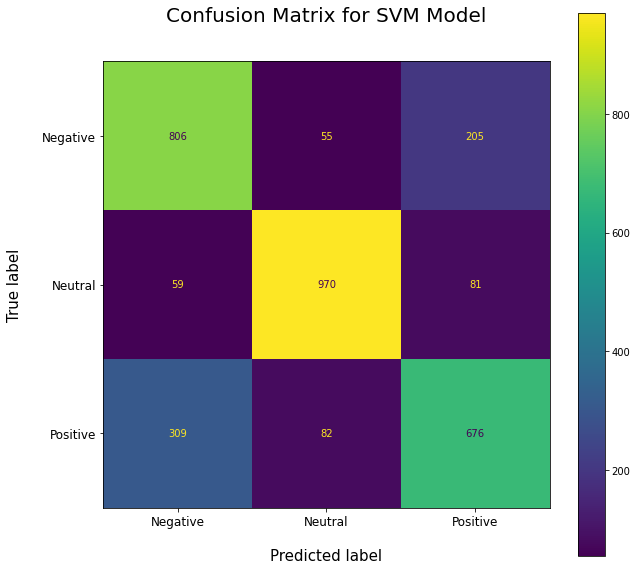

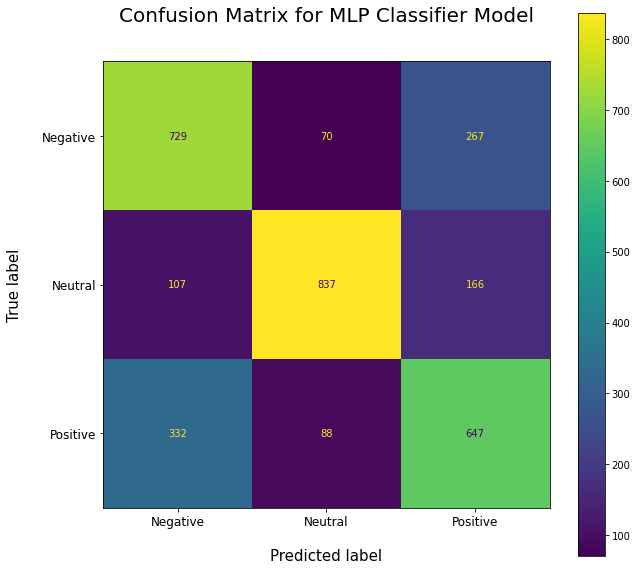

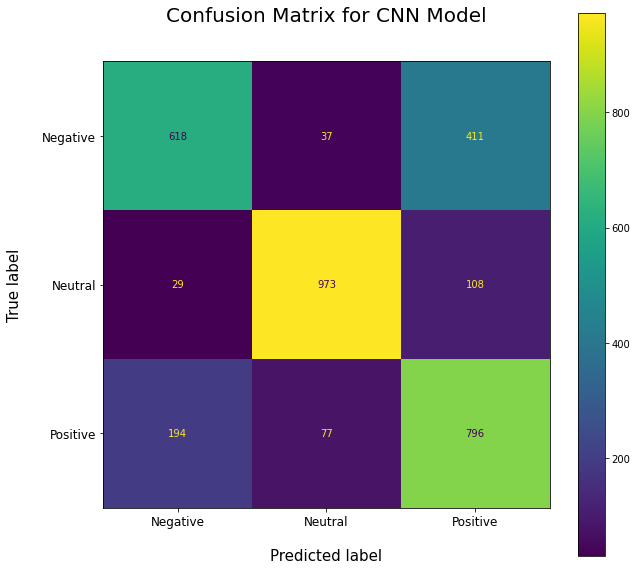

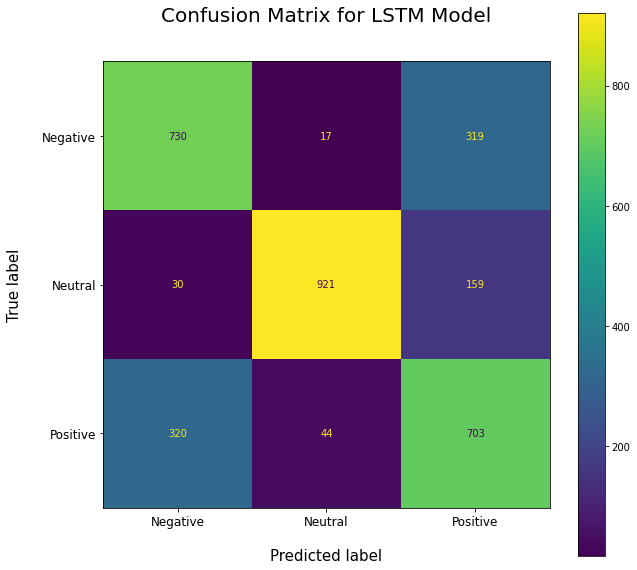

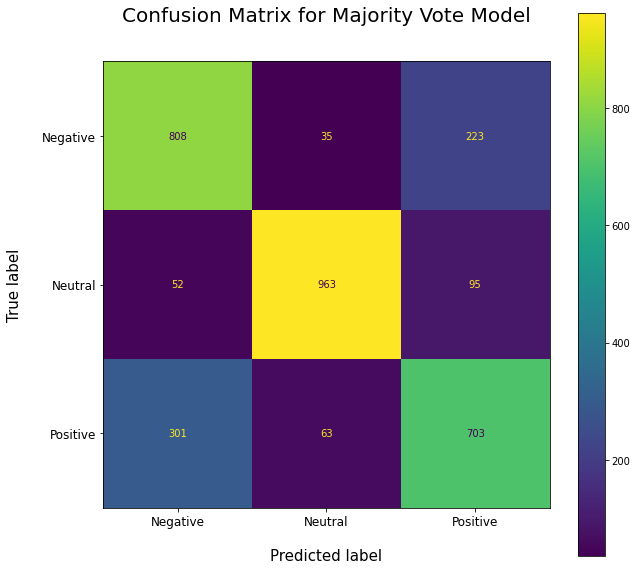

In [ ]:
for column in results.columns[:-1]:
    cm = confusion_matrix(Y_test, results[column])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative','Neutral','Positive'])
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title(label = 'Confusion Matrix for '+column+' Model', fontdict={'fontsize':20}, pad=40)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Predicted Label", fontdict={'fontsize':15}, labelpad=20)
    plt.ylabel("True Label", fontdict={'fontsize':15}, labelpad=20)
    disp.plot(ax=ax,values_format = '')

# Timeseries

In [ ]:
sorted_results=results.sort_values('Timestamp')

In [ ]:
sorted_results

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes,XGB Classifier,SVM,MLP Classifier,CNN,LSTM,Majority Vote,Timestamp
2591,neutral,positive,positive,neutral,neutral,neutral,neutral,neutral,positive,neutral,2009-04-06 22:38:47+00:00
2875,positive,positive,positive,positive,positive,positive,negative,positive,positive,positive,2009-04-06 22:55:40+00:00
2114,positive,positive,positive,negative,positive,positive,negative,positive,negative,positive,2009-04-06 23:08:23+00:00
409,negative,neutral,neutral,negative,neutral,neutral,negative,neutral,neutral,neutral,2009-04-06 23:43:16+00:00
1600,negative,positive,positive,positive,positive,negative,positive,positive,positive,positive,2009-04-07 00:07:05+00:00
...,...,...,...,...,...,...,...,...,...,...,...
438,neutral,positive,neutral,neutral,positive,neutral,neutral,neutral,neutral,neutral,2015-02-24 10:36:00+00:00
3052,neutral,positive,neutral,neutral,positive,neutral,neutral,neutral,neutral,neutral,2015-02-24 10:46:00+00:00
2013,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2015-02-24 11:08:00+00:00
303,neutral,positive,neutral,neutral,negative,neutral,negative,neutral,positive,neutral,2015-02-24 11:09:00+00:00


In [ ]:
sorted_results.reset_index(inplace=True,drop=True)

In [ ]:
sorted_results['Timestamp'] = pd.to_datetime(sorted_results['Timestamp'], utc=True)

In [ ]:
def ht(x):
    return x.strftime("%Y-%m-%d %H")

In [ ]:
def dayt(x):
    return x.strftime("%Y-%m-%d")

In [ ]:
sorted_results['hour']=sorted_results['Timestamp'].apply(ht)

In [ ]:
sorted_results['day']=sorted_results['Timestamp'].apply(dayt)

In [ ]:
ke={'positive':1,'negative':-1,'neutral':0}

In [ ]:
sorted_results.columns[:10]

Index(['Logistic Regression', 'Decision Tree Classifier',
       'Random Forest Classifier', 'Multinomial Naive Bayes', 'XGB Classifier',
       'SVM', 'MLP Classifier', 'CNN', 'LSTM', 'Majority Vote'],
      dtype='object')

In [ ]:
for column in sorted_results.columns[:10]:
    sorted_results[column+' (encoded)']=sorted_results[column].apply(lambda x:ke[x])

In [ ]:
sorted_results

,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes,XGB Classifier,SVM,MLP Classifier,CNN,LSTM,Majority Vote,Timestamp,hour,day,Logistic Regression (encoded),Decision Tree Classifier (encoded),Random Forest Classifier (encoded),Multinomial Naive Bayes (encoded),XGB Classifier (encoded),SVM (encoded),MLP Classifier (encoded),CNN (encoded),LSTM (encoded),Majority Vote (encoded)
0,neutral,positive,positive,neutral,neutral,neutral,neutral,neutral,positive,neutral,2009-04-06 22:38:47+00:00,2009-04-06 22,2009-04-06,0,1,1,0,0,0,0,0,1,0
1,positive,positive,positive,positive,positive,positive,negative,positive,positive,positive,2009-04-06 22:55:40+00:00,2009-04-06 22,2009-04-06,1,1,1,1,1,1,-1,1,1,1
2,positive,positive,positive,negative,positive,positive,negative,positive,negative,positive,2009-04-06 23:08:23+00:00,2009-04-06 23,2009-04-06,1,1,1,-1,1,1,-1,1,-1,1
3,negative,neutral,neutral,negative,neutral,neutral,negative,neutral,neutral,neutral,2009-04-06 23:43:16+00:00,2009-04-06 23,2009-04-06,-1,0,0,-1,0,0,-1,0,0,0
4,negative,positive,positive,positive,positive,negative,positive,positive,positive,positive,2009-04-07 00:07:05+00:00,2009-04-07 00,2009-04-07,-1,1,1,1,1,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3238,neutral,positive,neutral,neutral,positive,neutral,neutral,neutral,neutral,neutral,2015-02-24 10:36:00+00:00,2015-02-24 10,2015-02-24,0,1,0,0,1,0,0,0,0,0
3239,neutral,positive,neutral,neutral,positive,neutral,neutral,neutral,neutral,neutral,2015-02-24 10:46:00+00:00,2015-02-24 10,2015-02-24,0,1,0,0,1,0,0,0,0,0
3240,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,2015-02-24 11:08:00+00:00,2015-02-24 11,2015-02-24,0,0,0,0,0,0,0,0,0,0
3241,neutral,positive,neutral,neutral,negative,neutral,negative,neutral,positive,neutral,2015-02-24 11:09:00+00:00,2015-02-24 11,2015-02-24,0,1,0,0,-1,0,-1,0,1,0


In [ ]:
sorted_results.columns[-10:]

Index(['Logistic Regression (encoded)', 'Decision Tree Classifier (encoded)',
       'Random Forest Classifier (encoded)',
       'Multinomial Naive Bayes (encoded)', 'XGB Classifier (encoded)',
       'SVM (encoded)', 'MLP Classifier (encoded)', 'CNN (encoded)',
       'LSTM (encoded)', 'Majority Vote (encoded)'],
      dtype='object')

In [ ]:
classifier = 'Logistic Regression (encoded)'

hours=[]
scores=[]
for i in sorted_results.hour.unique():
    each=sorted_results[sorted_results['hour']==i][classifier].values
    hours.append(i+':00')
    scores.append(sum(each)/len(each))

In [ ]:
hourly=pd.DataFrame(zip(hours,scores),columns=['hours','scores'])

In [ ]:
days=[]
scores=[]
for i in sorted_results.day.unique():
    each=sorted_results[sorted_results['day']==i][classifier].values
    days.append(i)
    scores.append(sum(each)/len(each))

In [ ]:
daily=pd.DataFrame(zip(days,scores),columns=['days','scores'])

In [ ]:
hourly

,hours,scores
0,2009-04-06 22:00,0.500000
1,2009-04-06 23:00,0.000000
2,2009-04-07 00:00,0.000000
3,2009-04-07 01:00,1.000000
4,2009-04-07 02:00,1.000000
...,...,...
836,2015-02-24 07:00,0.166667
837,2015-02-24 08:00,1.000000
838,2015-02-24 09:00,0.000000
839,2015-02-24 10:00,0.000000


In [ ]:
hourly.shape

(841, 2)

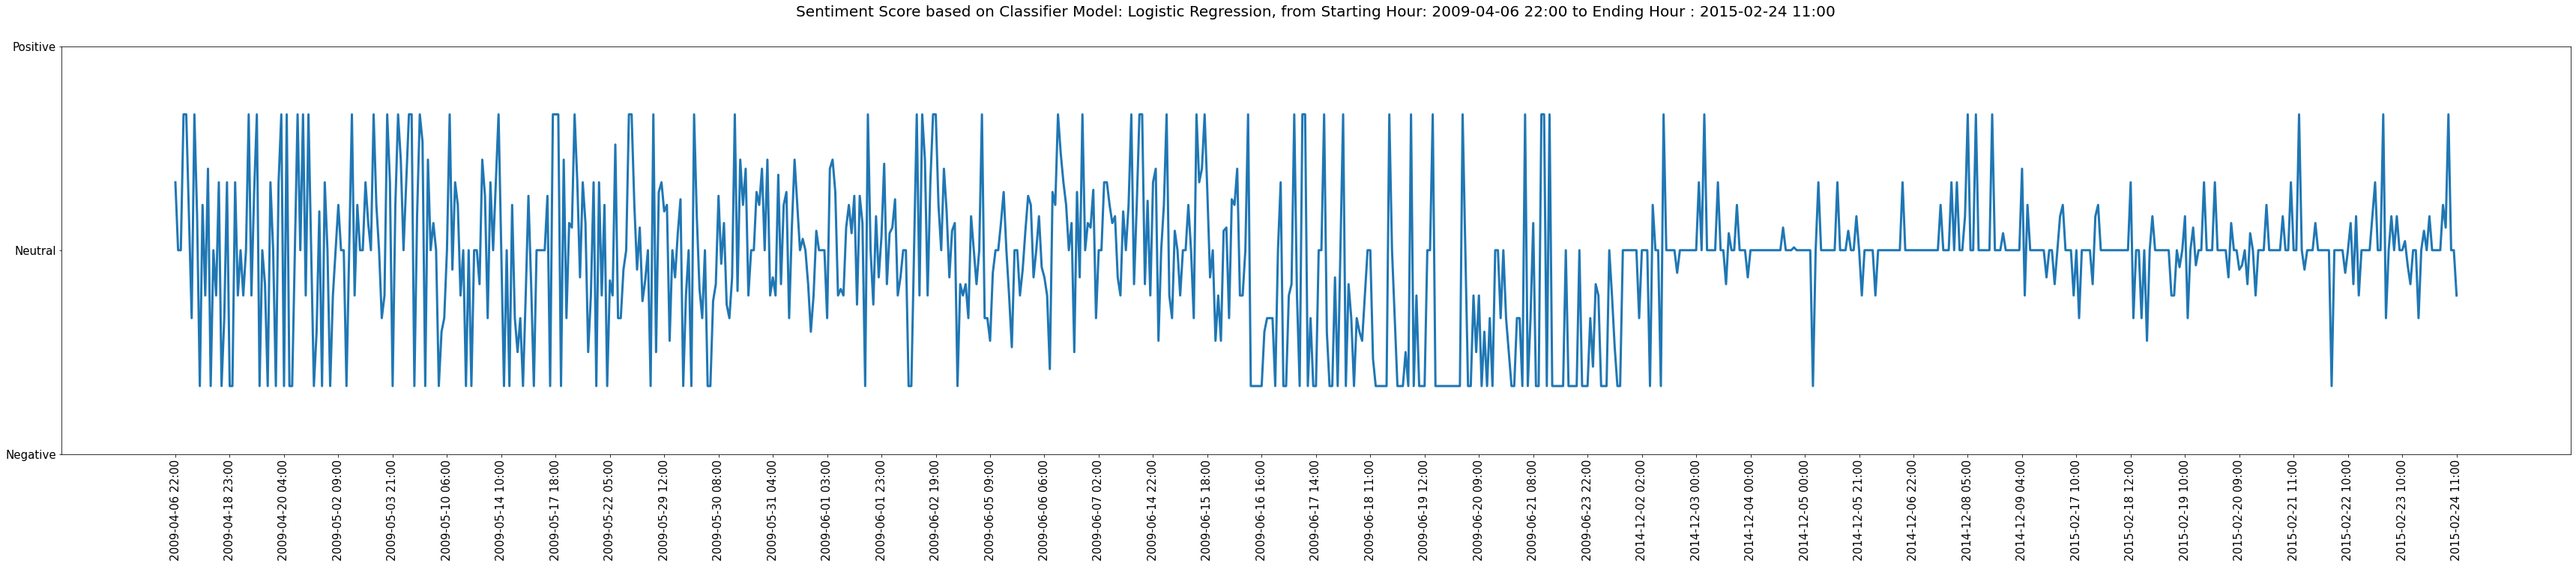

In [ ]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(60, 10))
ax = fig.add_subplot(111)
# Specify how our lines should look
ax.plot(hourly['hours'], hourly['scores'], color='tab:blue', label='Score',linewidth=3.0)
ax.set_xticks(ticks=np.arange(0, hourly.shape[0], 20))
plt.xticks(rotation=90)
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,-1,1))
ticks = [-1.5,0,1.5]
ax.set_yticks(ticks)
labels = ['Negative','Neutral','Positive']
ax.set_yticklabels(labels)
plt.title('Sentiment Score based on Classifier Model: '+classifier.split(' (')[0]+', from Starting Hour: '+hourly['hours'].values[0]+' to Ending Hour : '+hourly['hours'].values[-1], fontdict={'fontsize':20}, pad=40)
plt.show()

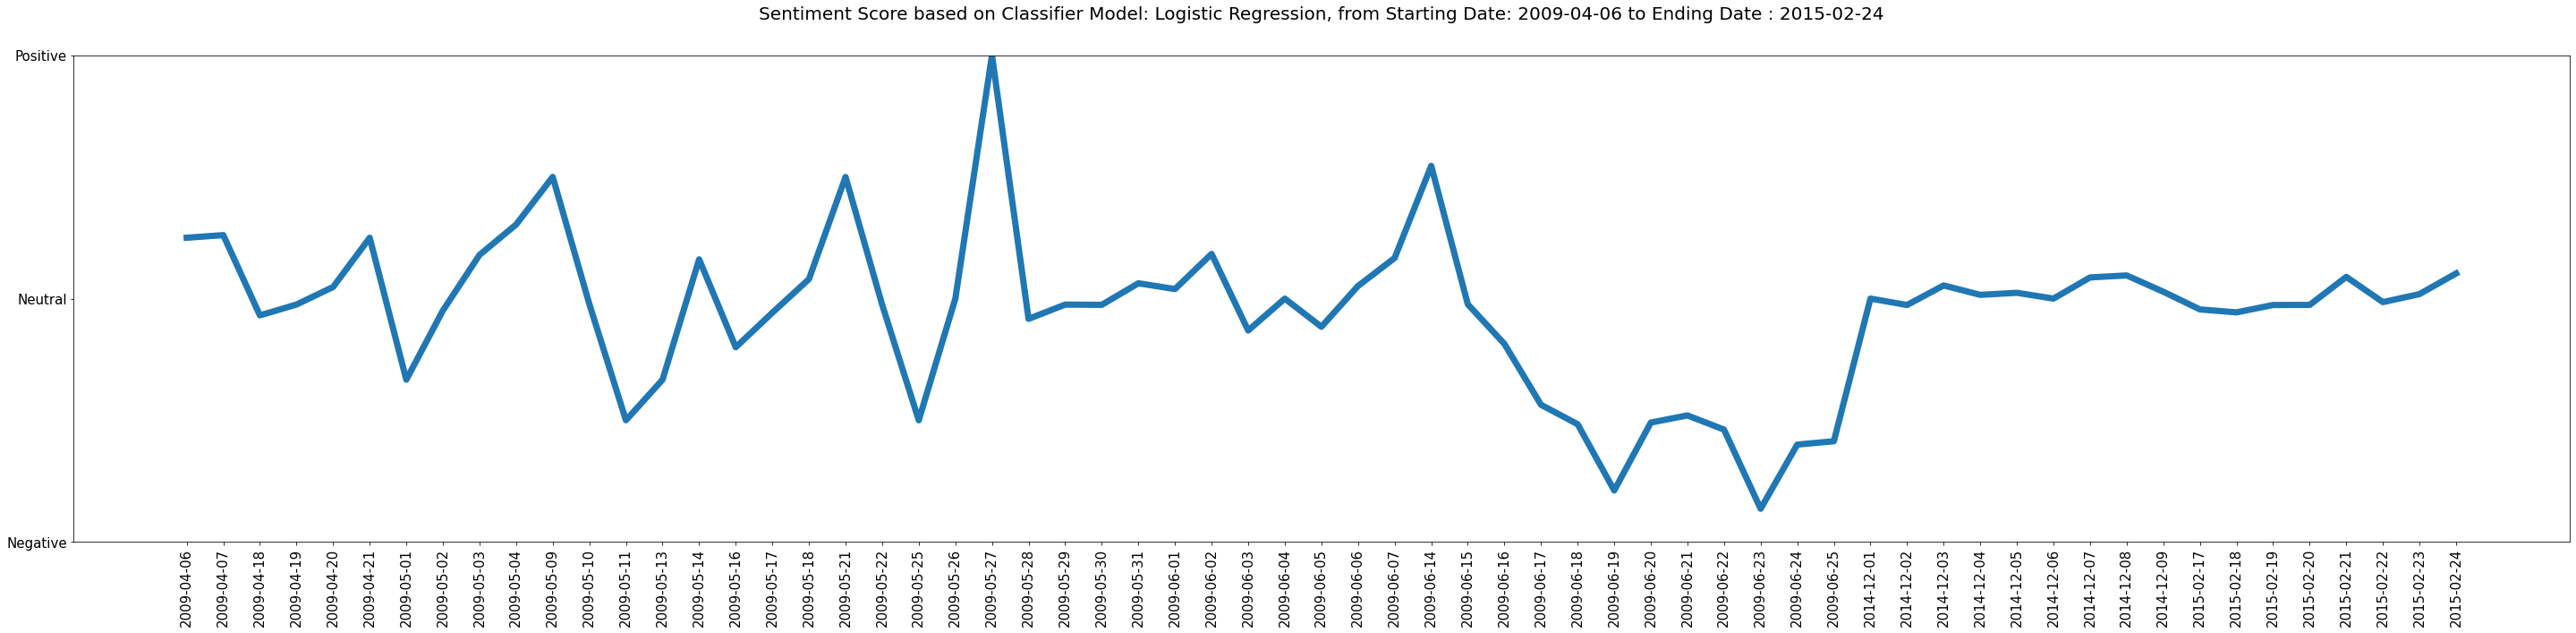

In [ ]:
plt.rc('font', size=15)
fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(111)

# Specify how our lines should look
ax.plot(daily['days'], daily['scores'], color='tab:blue', label='Score',linewidth=7.0)
plt.xticks(rotation=90)

x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,-1,1))
ticks = [-1.0,0,1.0]
ax.set_yticks(ticks)
labels = ['Negative','Neutral','Positive']
ax.set_yticklabels(labels)

plt.title('Sentiment Score based on Classifier Model: '+classifier.split(' (')[0]+', from Starting Date: '+daily['days'].values[0]+' to Ending Date : '+daily['days'].values[-1], fontdict={'fontsize':20}, pad=40)
plt.show()

# Last 100 predictions

In [ ]:
hundred_test_preds=glob.glob('/content/models/*/*[!full]_test_preds.csv')

In [ ]:
hundred_test_preds

['/content/models/MLPClassifier/MLPClassifier_test_preds.csv',
 '/content/models/MultinomialNB/MultinomialNB_test_preds.csv',
 '/content/models/lstm/lstm_test_preds.csv',
 '/content/models/RandomForestClassifier/RandomForestClassifier_test_preds.csv',
 '/content/models/LogisticRegression/LogisticRegression_test_preds.csv',
 '/content/models/XGBClassifier/XGBClassifier_test_preds.csv',
 '/content/models/DecisionTreeClassifier/DecisionTreeClassifier_test_preds.csv',
 '/content/models/cnn/cnn_test_preds.csv',
 '/content/models/svm/svm_test_preds.csv']

In [ ]:
hundred_train_preds=glob.glob('/content/models/*/*[!full]_train_preds.csv')

In [ ]:
hundred_test_preds

['/content/models/MLPClassifier/MLPClassifier_test_preds.csv',
 '/content/models/MultinomialNB/MultinomialNB_test_preds.csv',
 '/content/models/lstm/lstm_test_preds.csv',
 '/content/models/RandomForestClassifier/RandomForestClassifier_test_preds.csv',
 '/content/models/LogisticRegression/LogisticRegression_test_preds.csv',
 '/content/models/XGBClassifier/XGBClassifier_test_preds.csv',
 '/content/models/DecisionTreeClassifier/DecisionTreeClassifier_test_preds.csv',
 '/content/models/cnn/cnn_test_preds.csv',
 '/content/models/svm/svm_test_preds.csv']

In [ ]:
pd.read_csv(hundred_test_preds[0])

,Predicted (Test),True (Test)
0,['negative'],negative
1,['neutral'],neutral
2,['positive'],positive
3,['positive'],negative
4,['positive'],negative
...,...,...
95,['positive'],neutral
96,['neutral'],neutral
97,['negative'],positive
98,['neutral'],neutral


In [ ]:
pd.read_csv(hundred_train_preds[0])

,Predicted (Train),True (Train)
0,['positive'],positive
1,['positive'],positive
2,['neutral'],neutral
3,['neutral'],neutral
4,['negative'],negative
...,...,...
95,['positive'],positive
96,['negative'],negative
97,['negative'],negative
98,['neutral'],neutral
